In [106]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Input, Embedding, Flatten, Concatenate, Lambda, Dropout, BatchNormalization
from keras import regularizers, losses
from keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, LabelEncoder
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split as sklearn_train_test_split
from tensorflow.keras.losses import MeanSquaredError

import os

In [107]:
# Utility functions
def pclip(p):
    """Clip recall probability to avoid numerical issues."""
    return p.clip(0.0001, 0.9999)


def hclip(h):
    min_half_life = 15.0 / (24 * 60)  # 15 minutes in days
    max_half_life = 274.0   
    """Clip half-life to a reasonable range."""
    return h.clip(min_half_life, max_half_life)


In [108]:
current_dir = os.getcwd()
filename = 'df_processed.csv'
filepath = os.path.normpath(os.path.join(current_dir, '../data/processed/', filename))

chunk_size = 10000
chunks = []

for chunk in pd.read_csv(filepath, chunksize=chunk_size):
    chunk.drop_duplicates(inplace=True)
    chunk.dropna(inplace=True)
    chunks.append(chunk)

df = pd.concat(chunks, ignore_index=True)
df_users = pd.read_csv(os.path.normpath(os.path.join(current_dir, '../data/features/', 'users_behaviur.csv')))
df_words = pd.read_csv(os.path.normpath(os.path.join(current_dir, '../data/features/', 'word_complexity_features.csv')), sep='\t')
dff = pd.merge(pd.merge(df_words, df, on = 'lexeme_id', how='inner'), df_users, on = ['user_id', 'lang_combination'], how='inner')

In [109]:
# # Undersampling
# from sklearn.utils import resample

# Create bins: More focus on lower p_recall values
# bins = [0.0, 0.2, 0.4, 0.6, 0.8, 0.95, 1.01]  # 1.01 ensures we include 1.0
# bin_labels = [0, 1, 2, 3, 4, 5]  # Assign numeric labels
# dff['bin'] = pd.cut(dff['p_recall'], bins=bins, labels=bin_labels)


# dff[['p_recall', 'bin']]

# # Count the samples in each bin
# dff['bin'].value_counts()


# # # Separate majority and minority classes
# majority = dff[dff['bin'] == 5]  # The bin where p_recall ≈ 1.0
# minorities = dff[dff['bin'] < 5]  # All lower bins

# # # Undersample the majority class (reduce number of 1.0 values)
# majority_downsampled = resample(majority,
#                                 replace=False,  # No duplication, just remove some
#                                 n_samples=int(len(minorities) * 1.2),  # Keep some high values
#                                 random_state=42)

# # # Oversample minority classes (increase lower p_recall values)
# minorities_upsampled = resample(minorities,
#                                 replace=True,  # Duplicate low-value cases
#                                 n_samples=len(majority_downsampled),  # Balance dataset
#                                 random_state=42)

# # # Combine the balanced dataset
# df_balanced = pd.concat([majority_downsampled, minorities_upsampled])

# # # Shuffle the dataset
# df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

# dff = df_balanced.copy()
# dff.drop(columns='bin', inplace=True)


# # # Get the indices of resampled data
# # resampled_indices = df_balanced.index

# # # Apply sampling to feature matrices and labels
# # X_train_resampled = X_train.iloc[resampled_indices]
# # y_train_p_recall_resampled = y_train_p_recall.iloc[resampled_indices]
# # y_train_half_life_resampled = y_train_half_life.iloc[resampled_indices]

In [110]:
cols_to_drop = ['lexeme_id' ,'gender', 'def', 'tense', 'POS', 'person', 'number', 'word',
                'session_seen', 'session_correct', 'avg_user_p_recall', 'timestamp', 'user_id', 
                'learning_language', 'ui_language']
dff.drop(columns=cols_to_drop, inplace=True)
dff.dropna(inplace=True)

# dff.drop(columns=['h_recall'], inplace=True)

In [111]:
# columns transformation
dff['delta'] = dff['delta']/(60*60*24) # convert time delta to days
dff['avg_delta'] = np.sqrt(dff['avg_delta']/(60*60*24)) 
dff['std_delta'] = np.sqrt(dff['std_delta']/(60*60*24)+1e-10)
dff['p_recall'] = pclip(dff['p_recall'])
dff['half_life'] = hclip(-dff['delta']/np.log2(dff['p_recall']))
dff['history_wrong'] = np.log2(1+(dff['history_seen'] - dff['history_correct']))
dff['history_seen'] = np.log2((1+dff['history_seen']))
dff['history_correct'] = np.log2(1+dff['history_correct'])
dff['SUBTLEX'] = np.log2(dff['SUBTLEX'])

In [112]:
dff

,word_len,tags_list,SUBTLEX,p_recall,delta,history_seen,history_correct,h_recall,lang_combination,avg_delta,std_delta,avg_h_recall,half_life,history_wrong
0,5,"['vblex', 'pri', 'p3', 'sg']",11.727495,0.9999,0.069016,3.169925,2.807355,0.750000,en-de,0.189554,0.185626,0.890225,274.000000,1.584963
1,5,"['vblex', 'pri', 'p3', 'sg']",11.727495,0.0001,0.002928,3.906891,3.700440,0.857143,en-de,0.189554,0.185626,0.890225,0.010417,1.584963
2,5,"['vblex', 'pri', 'p3', 'sg']",11.727495,0.9999,0.000752,4.000000,3.700440,0.800000,en-de,0.189554,0.185626,0.890225,5.214388,2.000000
3,5,"['vblex', 'pri', 'p3', 'sg']",11.727495,0.5000,0.000313,4.087463,3.807355,0.812500,en-de,0.189554,0.185626,0.890225,0.010417,2.000000
4,5,"['vblex', 'pri', 'p3', 'sg']",11.727495,0.9999,0.002072,4.000000,4.000000,1.000000,en-de,1.004927,1.278230,0.914070,14.359623,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12509996,7,"['n', 'f']",9.887221,0.9999,0.418218,1.000000,1.000000,1.000000,en-de,1.653808,2.289050,0.929407,274.000000,0.000000
12509997,9,"['vblex', 'prs']",16.030236,0.9999,4.484850,1.584963,1.000000,0.500000,en-pt,1.218573,2.336023,0.928925,274.000000,1.000000
12509998,9,"['vblex', 'prs']",16.030236,0.0001,0.075845,2.000000,1.584963,0.666667,en-pt,1.218573,2.336023,0.928925,0.010417,1.000000
12509999,5,"['vblex', 'prs']",13.656201,0.9999,0.075845,1.584963,1.000000,0.500000,en-pt,1.218573,2.336023,0.928925,274.000000,1.000000


In [113]:
dff.select_dtypes(include='number').skew()

word_len           0.720826
SUBTLEX            0.135312
p_recall          -2.661312
delta              3.542299
history_seen       0.931155
history_correct    0.929852
h_recall          -1.633217
avg_delta          1.297604
std_delta          0.635642
avg_h_recall      -1.710594
half_life         -0.159647
history_wrong      1.385843
dtype: float64

In [114]:
dff.describe().map(lambda x: f"{x:0.3f}")

,word_len,SUBTLEX,p_recall,delta,history_seen,history_correct,h_recall,avg_delta,std_delta,avg_h_recall,half_life,history_wrong
count,12505498.000,12505498.000,12505498.000,12505498.000,12505498.000,12505498.000,12505498.000,12505498.000,12505498.000,12505498.000,12505498.000,12505498.000
mean,4.745,16.570,0.897,5.424,3.182,3.041,0.901,1.974,2.203,0.901,155.476,0.862
std,2.040,3.806,0.270,11.760,1.413,1.408,0.136,1.236,1.236,0.048,124.083,1.049
min,1.000,0.000,0.000,0.000,1.000,1.000,0.045,0.003,0.000,0.333,0.010,0.000
25%,3.000,13.660,1.000,0.006,2.000,2.000,0.833,1.116,1.299,0.880,19.093,0.000
50%,5.000,16.072,1.000,0.841,2.807,2.807,0.964,1.712,1.981,0.906,274.000,1.000
75%,6.000,19.622,1.000,4.843,4.000,3.807,1.000,2.570,2.982,0.929,274.000,1.585
max,22.000,24.779,1.000,86.448,8.683,8.476,1.000,9.290,7.747,1.000,274.000,8.082


In [115]:
# Encoding tags and langs 
tag_encoder = LabelEncoder()
lang_encoder = LabelEncoder()

dff['tags_list'] = tag_encoder.fit_transform(dff['tags_list'])
dff['lang_combination'] = lang_encoder.fit_transform(dff['lang_combination'])

In [116]:
def prepare_dataset(df):
    categorical_features = df.select_dtypes(include='O').columns
    numeric_features = df.select_dtypes(exclude=['O']).columns.drop(['p_recall', 'half_life', 'delta'])

    scaler = MinMaxScaler()
    df[numeric_features] = scaler.fit_transform(df[numeric_features])
    return df, categorical_features, numeric_features 

dff_1, categorical_features, numeric_features = prepare_dataset(dff)

In [117]:
# Train test split
def split(df, numeric_features): 
    
    X = df.drop(columns=['p_recall', 'half_life'])
    y = df[['p_recall', 'half_life']]
    
    X_train, X_test, y_train, y_test = sklearn_train_test_split(X,
                                                        y,
                                                        train_size=0.8,
                                                        random_state=42)

    X_train_delta = X_train['delta'].to_numpy().reshape(-1,1)
    X_test_delta = X_test['delta'].to_numpy().reshape(-1,1)
    
    X_train_numerical = X_train[numeric_features].to_numpy()
    X_test_numerical = X_test[numeric_features].to_numpy()

    # Embeddings 
    X_train_tags = X_train['tags_list'].to_numpy().reshape(-1,1)
    X_train_langs = X_train['lang_combination'].to_numpy().reshape(-1,1)
    X_test_tags = X_test['tags_list'].to_numpy().reshape(-1,1)
    X_test_langs = X_test['lang_combination'].to_numpy().reshape(-1,1)
    

    y_train_p_recall = y_train['p_recall']
    y_train_half_life = y_train['half_life']
    y_test_p_recall = y_test['p_recall']
    y_test_half_life = y_test['half_life']

    # Embeddings 
    return df, X_train_tags, X_train_langs, X_train_numerical, X_test_tags, X_test_langs, X_test_numerical, X_train_delta, X_test_delta, X_test, y_train, y_test, y_train_half_life, y_train_p_recall, y_test_half_life, y_test_p_recall

    # No embeddings 
    # return df, X_train_delta, X_test_delta, X_train_numerical, X_test_numerical, y_train_p_recall, y_train_half_life, y_test_p_recall, y_test_half_life

# Embeddings 
df, X_train_tags, X_train_langs, X_train_numerical, X_test_tags, X_test_langs, X_test_numerical, X_train_delta, X_test_delta, X_test, y_train, y_test, y_train_half_life, y_train_p_recall, y_test_half_life, y_test_p_recall = split(dff_1.sample(frac=1), numeric_features)


# No embeddings
# df, X_train_delta, X_test_delta, X_train_numerical, X_test_numerical, y_train_p_recall, y_train_half_life, y_test_p_recall, y_test_half_life = split(dff_1.sample(frac=0.1), numeric_features)

In [118]:
# print('X_train_tags_size', X_train_tags.shape)
# print('X_train_langs_size', X_train_langs.shape)
# print('X_train_numerical_size', X_train_numerical.shape)
# print('X_test_tags_size', X_test_tags.shape)
# print('X_test_langs_size', X_test_langs.shape)
# print('X_test_numerical_size', X_test_numerical.shape)
# print('y_train_half_life_size', y_train_half_life.shape)
# print('y_train_p_recall_size', y_train_p_recall.shape)
# print('y_test_half_life_size', y_test_half_life.size)
# print('y_test_p_recall_size', y_test_p_recall.size)

In [136]:
def compute_custom_weights(y_train_p_recall, y_train_half_life): 
    num_bins = 10
    y_combined = y_train_p_recall + y_train_half_life

    bins = np.quantile(y_combined, np.linspace(0, 1, num_bins + 1))
    bin_indices = np.digitize(y_combined, bins, right=True)
    bin_counts = np.bincount(bin_indices, minlength=num_bins + 1)
    bin_freqs = bin_counts / len(y_train)

    # Assign inverse weights
    bin_weights = 1 / (bin_freqs + 1e-6) 
    sample_weights = bin_weights[bin_indices]
    return sample_weights

sample_weights = compute_custom_weights(y_train_p_recall, y_train_half_life)

In [138]:
# Embeddings
def emb_layers(df): 
    len_tags = len(np.unique(df['tags_list']))
    len_langs = len(np.unique(df['lang_combination']))
    
    embedding_tags_size = int(min(np.ceil((len_tags)/2), 50))
    embedding_langs_size = int(min(np.ceil((len_langs)/2), 50))
    
    tags_input = Input(shape=(1,))  
    langs_input = Input(shape=(1,))  
    
    tags_embedded = Embedding(input_dim=len_tags, output_dim=embedding_tags_size)(tags_input)  
    langs_embedded = Embedding(input_dim=len_langs, output_dim=embedding_langs_size)(langs_input)  
    
    flattened_tags = Flatten()(tags_embedded)
    flattened_langs = Flatten()(langs_embedded)
    
    numerical_input = Input(shape=(len(numeric_features),)) 
    delta_input = Input(shape=(1,))  
    
    # Concatenate layers
    conc_layers = [flattened_tags, flattened_langs, numerical_input]
    conc = Concatenate()(conc_layers)
    return conc, numerical_input, delta_input, tags_input, langs_input

conc, numerical_input, delta_input, tags_input, langs_input = emb_layers(df)

In [139]:
def nhlr_loss(y_true, y_pred):
    h_true, p_true = y_true[0], y_true[1]
    h_pred, p_pred = y_pred[0], y_pred[1]

    slh = tf.reduce_mean(tf.square(h_true - h_pred)) # half-life loss 
    slp = tf.reduce_mean(tf.square(p_true - p_pred)) # p_recall loss 

    return slp + slh 

In [140]:
# Neural Network Architectture
hidden_dim = 16
l2wt = 0.1            
learning_rate = 0.001
epochs = 10
batch_size = 512

x = Dense(hidden_dim, activation="relu", kernel_regularizer=regularizers.l2(l2wt))(conc)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)

# Second layer
# x = Dense(hidden_dim, activation="relu", kernel_regularizer=regularizers.l2(l2wt))(x)

half_life_output = Dense(1, activation="relu", name="half_life")(x) 
p_recall_output = Lambda(lambda inputs: tf.pow(2.0, -inputs[0] / (inputs[1] + 1e-6)), 
                         name="p_recall")([delta_input, half_life_output])


In [141]:
# print("Max tag index:", X_train_tags.max(), "Embedding input_dim:", len_tags)
# print("Max lang index:", X_train_langs.max(), "Embedding input_dim:", len_langs)

# print("Tags Input Shape:", tags_input.shape)
# print("Langs Input Shape:", langs_input.shape)
# print("Numerical Input Shape:", numerical_input.shape)

# print("Flattened tags Embedded Shape:", flattened_tags.shape)
# print("Flattened Langs Embedded Shape:", flattened_langs.shape)
# print("Flattened Numerical Input Shape:", numerical_input.shape)

# print("X_train_tags shape:", X_train_tags.shape)    
# print("X_train_langs shape:", X_train_langs.shape)  
# print("X_train_numerical shape:", X_train_numerical.shape)  
# print("X_train_delta shape:", X_train_delta.shape)  


# print(y_train_half_life.shape)
# print(y_train_p_recall.shape)


In [143]:
inputs_list = [tags_input, langs_input, numerical_input, delta_input]
X_train_list = [X_train_tags, X_train_langs, X_train_numerical, X_train_delta]

model = Model(inputs=inputs_list, outputs=[half_life_output, p_recall_output])

model.compile(loss=nhlr_loss, optimizer= Adam(learning_rate=learning_rate), metrics=['MAE', 'MAE'])
model.fit(X_train_list, [y_train_half_life, y_train_p_recall], epochs=epochs, batch_size=batch_size, verbose=2, sample_weight = sample_weights)
model.summary()

Epoch 1/10
19540/19540 - 11s - 559us/step - half_life_MAE: 118.4321 - half_life_loss: 204595.0469 - loss: 204601.3594 - p_recall_MAE: 0.1452 - p_recall_loss: 1.3120
Epoch 2/10
19540/19540 - 10s - 534us/step - half_life_MAE: 112.6780 - half_life_loss: 175144.1875 - loss: 175149.1406 - p_recall_MAE: 0.1207 - p_recall_loss: 1.0096
Epoch 3/10
19540/19540 - 10s - 534us/step - half_life_MAE: 111.7871 - half_life_loss: 174292.2812 - loss: 174296.7500 - p_recall_MAE: 0.1166 - p_recall_loss: 0.9767
Epoch 4/10
19540/19540 - 10s - 537us/step - half_life_MAE: 111.4026 - half_life_loss: 172580.2656 - loss: 172584.4844 - p_recall_MAE: 0.1160 - p_recall_loss: 0.9874
Epoch 5/10
19540/19540 - 10s - 534us/step - half_life_MAE: 111.1027 - half_life_loss: 173284.1406 - loss: 173288.1094 - p_recall_MAE: 0.1163 - p_recall_loss: 0.9957
Epoch 6/10
19540/19540 - 11s - 562us/step - half_life_MAE: 111.6728 - half_life_loss: 172157.9375 - loss: 172162.1250 - p_recall_MAE: 0.1161 - p_recall_loss: 0.9589
Epoch 7/10

Model: "functional_8"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_12      │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_13      │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_6         │ (None, 1, 50)     │     20,050 │ input_layer_12[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_7         │ (None, 1, 4)      │         32 │ input_layer_13[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_6 (Flatten) │ (None, 50)        │          0 │ embedding_6[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_7 (Flatten) │ (None, 4)         │          0 │ embedding_7[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_14      │ (None, 11)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_3       │ (None, 65)        │          0 │ flatten_6[0][0],  │
│ (Concatenate)       │                   │            │ flatten_7[0][0],  │
│                     │                   │            │ input_layer_14[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_9 (Dense)     │ (None, 16)        │      1,056 │ concatenate_3[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 16)        │         64 │ dense_9[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_7 (Dropout) │ (None, 16)        │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ half_life (Dense)   │ (None, 1)         │         17 │ dropout_7[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_15      │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ p_recall (Lambda)   │ (None, 1)         │          0 │ input_layer_15[0… │
│                     │                   │            │ half_life[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 63,595 (248.42 KB)

 Trainable params: 21,187 (82.76 KB)

 Non-trainable params: 32 (128.00 B)

 Optimizer params: 42,376 (165.54 KB)

In [144]:
# def build_model(hidden_dim=8, learning_rate=0.001):
#     from tensorflow.keras.models import Model
#     from tensorflow.keras.layers import Dense, Input, Lambda
#     import tensorflow as tf
#     from tensorflow.keras.optimizers import Adam

#     # Inputs
#     numerical_input = Input(shape=(X_train.shape[1],), name="numerical_input")
#     delta_input = Input(shape=(1,), name="delta_input")

#     # Hidden layer
#     x = Dense(hidden_dim, activation="relu")(numerical_input)

#     # Outputs
#     half_life_output = Dense(1, activation="relu", name="half_life")(x)
#     p_recall_output = Lambda(lambda inputs: tf.pow(2.0, -inputs[0] / (inputs[1] + 1e-6)),
#                              name="p_recall")([delta_input, half_life_output])

#     # Define model
#     model = Model(inputs=[numerical_input, delta_input], outputs=[half_life_output, p_recall_output])
#     model.compile(loss="mse", optimizer=Adam(learning_rate=learning_rate), metrics=['mae'])
    
#     return model



In [145]:
# from sklearn.model_selection import GridSearchCV 
# from sklearn.metrics import make_scorer, r2_score
# from scikeras.wrappers import KerasRegressor


# X_train = np.concatenate([X_train_tags, X_train_langs, X_train_numerical, X_train_delta], axis=1)
# y_train = np.column_stack([y_train_half_life, y_train_p_recall])  # Shape: (1000440, 2)


# def multi_output_r2(y_true, y_pred):
#     r2_half_life = r2_score(y_true[:, 0], y_pred[:, 0])
#     r2_p_recall = r2_score(y_true[:, 1], y_pred[:, 1])
#     return (r2_half_life + r2_p_recall) / 2  # Average R² for both outputs

# scorer = make_scorer(multi_output_r2, greater_is_better=True)




# grid = {
#     'hidden_dims': [8,16,24],
#     'learning_rates': [0.001, 0.1],
#     'batches': [32, 64, 128, 512]
# }

# classifier = KerasRegressor(build_fn=build_model)
# grid_search = GridSearchCV(estimator = classifier,
#                            param_grid = grid,
#                            scoring = scorer,
#                            cv=3)
# grid_search = grid_search.fit(X_train, y_train, verbose = 2)




In [146]:
# best_parameters = grid_search.best_params_
# best_score = grid_search.best_score_

# print("Best Parameters: " + str(best_parameters))
# print(f'Best Accuracy for {grid_result.best_score_:.4} using {grid_result.best_params_}')


In [147]:
# Predict 
y_pred_half_life, y_pred_p_recall  = model.predict([X_test_tags, X_test_langs, X_test_numerical, X_test_delta])

78160/78160 ━━━━━━━━━━━━━━━━━━━━ 18s 232us/step


In [148]:
dff_results = X_test.copy()
dff_results['p_recall'] = y_test['p_recall']
dff_results['p_recall_pred'] = y_pred_p_recall
dff_results['diff'] = dff_results['p_recall'] - dff_results['p_recall_pred']
dff_results['half_life'] = y_test['half_life'] 
dff_results['half_life_pred'] = y_pred_half_life

In [149]:
dff_results.sort_values(by='diff')

,word_len,tags_list,SUBTLEX,delta,history_seen,history_correct,h_recall,lang_combination,avg_delta,std_delta,avg_h_recall,history_wrong,p_recall,p_recall_pred,diff,half_life,half_life_pred
3357386,0.190476,0.1350,0.774747,0.000012,0.172059,0.078248,0.476190,1.000000,0.070138,0.091436,0.855148,0.196107,0.000100,1.0,-0.999900,0.010417,93.484848
6932700,0.047619,0.2850,0.816493,0.000012,0.235241,0.133766,0.476190,0.000000,0.127451,0.181290,0.679961,0.247459,0.000100,1.0,-0.999900,0.010417,107.849121
2467146,0.190476,0.1625,0.749713,0.000012,0.172059,0.133766,0.738095,0.142857,0.237600,0.273017,0.913709,0.123729,0.000100,1.0,-0.999900,0.010417,179.359055
9451004,0.190476,0.1725,0.546251,0.000012,0.235241,0.133766,0.476190,0.428571,0.165718,0.186701,0.637962,0.247459,0.000100,1.0,-0.999900,0.010417,130.726562
11287181,0.095238,0.0675,0.799561,0.000012,0.130158,0.000000,0.301587,0.000000,0.127451,0.181290,0.679961,0.196107,0.000100,1.0,-0.999900,0.010417,106.168694
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9853652,0.190476,0.0475,0.871153,0.001759,0.914014,0.831914,0.551020,0.714286,0.098220,0.311416,0.617015,0.842270,0.833333,0.0,0.833333,0.010417,0.000000
9853280,0.190476,0.0475,0.871153,0.001910,0.871208,0.776827,0.516875,0.714286,0.098220,0.311416,0.617015,0.814754,0.833333,0.0,0.833333,0.010417,0.000000
2408966,0.000000,0.1100,0.960009,0.012176,0.834231,0.776827,0.640462,0.714286,0.081360,0.257761,0.514075,0.727856,0.999900,0.0,0.999900,84.392867,0.000000
6990388,0.095238,0.0875,0.862581,0.901875,0.808207,0.701995,0.486880,0.285714,0.069449,0.154385,0.318563,0.765864,0.999900,0.0,0.999900,274.000000,0.000000


In [150]:
mae_p = np.mean(np.abs(dff_results['p_recall'] - dff_results['p_recall_pred']))
mae_h = np.mean(np.abs(dff_results['half_life'] - dff_results['half_life_pred']))
print(f"MAE on test set - p_recall: {mae_p:.4f}")
print(f"MAE on test set - half_life: {mae_h:.4f}")

MAE on test set - p_recall: 0.1153
MAE on test set - half_life: 110.2802


In [151]:
dff_results[['p_recall', 'p_recall_pred']].describe().apply(lambda s: s.apply('{0:.5f}'.format))

,p_recall,p_recall_pred
count,2501100.00000,2501100.00000
mean,0.89728,0.98022
std,0.26984,0.03982
min,0.00010,0.00000
25%,0.99990,0.98037
50%,0.99990,0.99620
75%,0.99990,0.99997
max,0.99990,1.00000


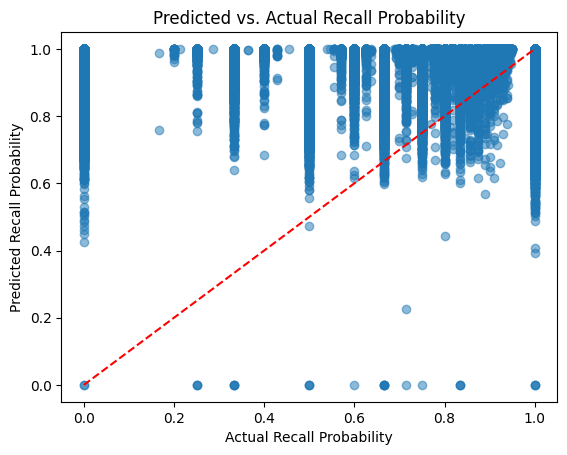

In [152]:
# Predicted vs Actual 
plt.scatter(dff_results['p_recall'], dff_results['p_recall_pred'], alpha=0.5)
plt.plot([0, 1], [0, 1], color="red", linestyle="--")
plt.xlabel("Actual Recall Probability")
plt.ylabel("Predicted Recall Probability")
plt.title("Predicted vs. Actual Recall Probability")
plt.show()

<Axes: >

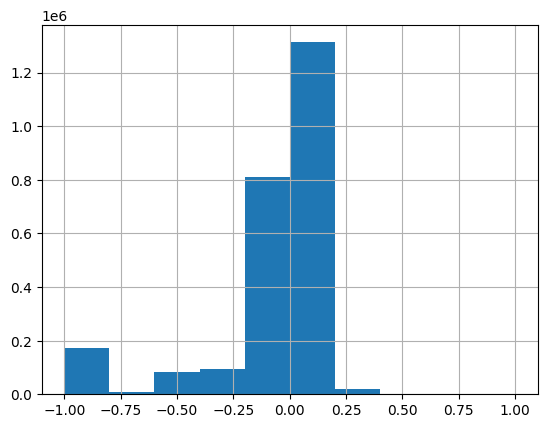

In [153]:
# Residuals histogram 
dff_results['diff'].hist()

In [35]:
X_train

NameError: name 'X_train' is not defined

In [ ]:
import shap 

# Initialize SHAP explainer
explainer = shap.Explainer(model, X_train_list)
shap_values = explainer([X_test_tags, X_test_langs, X_test_numerical, X_test_delta], max_evals=1500661)

# Plot summary
shap.summary_plot(shap_values, [X_test_tags, X_test_langs, X_test_numerical, X_test_delta], feature_names=numeric_features)
